In [ ]:
PRN no.: 22SC114501051
Title: Detecting algorithmic bias in hiring dataset

In [2]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, selection_rate

In [3]:
!pip install fairlearn

Defaulting to user installation because normal site-packages is not writeable


In [4]:
# Load dataset
#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("wenruliu/adult-income-dataset")

#print("Path to dataset files:", path)

In [5]:
data= pd.read_csv("adult.csv")

In [6]:
print(data.columns.values)

['age' 'workclass' 'fnlwgt' 'education' 'educational-num' 'marital-status'
 'occupation' 'relationship' 'race' 'gender' 'capital-gain' 'capital-loss'
 'hours-per-week' 'native-country' 'income']


In [7]:
# Preprocess
data = data[['age', 'educational-num', 'hours-per-week', 'gender', 'income']]
data = pd.get_dummies(data, drop_first=True)
#data = pd.get_dummies(data)

In [8]:
print(data.columns.values)

['age' 'educational-num' 'hours-per-week' 'gender_Male' 'income_>50K']


In [9]:
X = data.drop('income_>50K', axis=1)
y = data['income_>50K']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [11]:
print(y_pred)

[False False False ... False False False]


In [12]:
# Fairness evaluation
sex = X_test['gender_Male']
metric_frame = MetricFrame(metrics=selection_rate,
                           y_true=y_test,
                           y_pred=y_pred,
                           sensitive_features=sex)
print("Selection Rates by Gender:\n", metric_frame.by_group)

Selection Rates by Gender:
 gender_Male
False    0.013193
True     0.200775
Name: selection_rate, dtype: float64


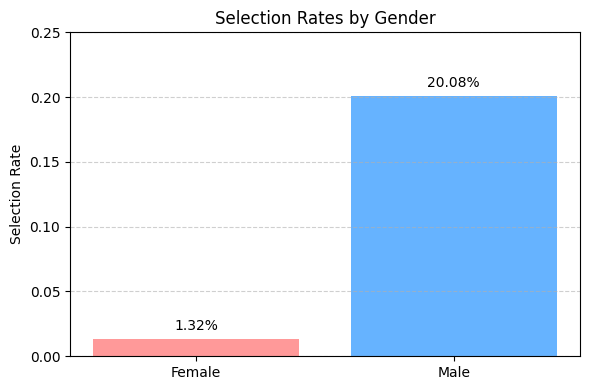

In [13]:
#Visualise this result
import matplotlib.pyplot as plt
import pandas as pd

# Selection rates from Fairlearn output
selection_rates = {
    'Female': 0.013193,
    'Male': 0.200775
}

# Convert to DataFrame
df = pd.DataFrame(list(selection_rates.items()), columns=["Gender", "Selection Rate"])

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(df["Gender"], df["Selection Rate"], color=["#ff9999", "#66b3ff"])
plt.title("Selection Rates by Gender")
plt.ylabel("Selection Rate")
plt.ylim(0, 0.25)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add percentage labels above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{yval:.2%}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

Interpretation:
This visual makes it very clear that the model predicts high income for men much more often than for women — highlighting strong gender bias.

In [14]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import MetricFrame, selection_rate

In [15]:
data = pd.read_csv("adult.csv")
print(data.columns.values)

['age' 'workclass' 'fnlwgt' 'education' 'educational-num' 'marital-status'
 'occupation' 'relationship' 'race' 'gender' 'capital-gain' 'capital-loss'
 'hours-per-week' 'native-country' 'income']


In [16]:
data = data[['age', 'educational-num', 'hours-per-week', 'gender', 'income']]
data = pd.get_dummies(data, drop_first=True)

In [17]:
# Prepare X and y
X = data.drop('income_>50K', axis=1)
y = data['income_>50K']
sensitive_feature = X['gender_Male']

In [18]:
X_train, X_test, y_train, y_test, sf_train, sf_test = train_test_split(
    X, y, sensitive_feature, test_size=0.3, random_state=42
)

In [19]:
# Define base estimator
estimator = LogisticRegression(max_iter=1000)

In [20]:
# Apply fairness constraint: Demographic Parity
fair_model = ExponentiatedGradient(
    estimator,
    constraints=DemographicParity(),
    eps=0.01  # fairness tolerance
)

In [21]:
# Fit fair model
fair_model.fit(X_train, y_train, sensitive_features=sf_train)

,estimator,LogisticRegre...max_iter=1000)
,constraints,<fairlearn.re...x7f9dea6892b0>
,objective,None
,eps,0.01
,max_iter,50
,nu,np.float64(0....8464333572777)
,eta0,2.0
,run_linprog_step,True
,sample_weight_name,'sample_weight'
,penalty,'l2'
,dual,False


In [22]:
# Predict
y_pred = fair_model.predict(X_test)

In [23]:
# Evaluate fairness and accuracy
metric_frame = MetricFrame(
    metrics={
        "Selection Rate": selection_rate,
        "Accuracy": accuracy_score
    },
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sf_test
)

In [24]:
print("Fair Model Evaluation by Gender:\n")
print(metric_frame.by_group)
print("\nOverall Accuracy:", accuracy_score(y_test, y_pred))

Fair Model Evaluation by Gender:

             Selection Rate  Accuracy
gender_Male                          
False              0.097506  0.865182
True               0.114466  0.749541

Overall Accuracy: 0.7878250187674879
